# Tensorflow 가 없다는 오류가 뜨신다면

1) Anaconda prompt를 관리자모드로 열어줍니다.

2) 명령어를 입력합니다: 
` conda update --force conda `

3) 명령어를 입력합니다:
` conda install tensorflow `

4) jupyter를 다시 실행합니다.

### 1. 라이브러리 import 하기

In [2]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf

from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image

### 2. Image Loading

In [17]:
X = []
Y = []

for i in tqdm(glob('./archive/train/Open_Eyes/*')):
    temp = np.array(Image.open(i).resize((64,64)))
    X.append(temp)
    Y.append(1)
    
for i in tqdm(glob('./archive/train/Closed_Eyes/*')):
    temp = np.array(Image.open(i).resize((64,64)))
    X.append(temp)
    Y.append(0)  

100%|██████████| 2000/2000 [00:01<00:00, 1401.07it/s]


### 3. Normalizing the images using Min-Max Scaling algorithm

In [19]:
X = (np.array(X) - np.min(X)) / (np.max(X) - np.min(X))
X = X/255.0
Y = (np.array(Y) - np.min(Y)) / (np.max(Y) - np.min(Y))

### 4. Normalizing the images using Z-Score algorithm

In [20]:
# X = (np.array(X) - np.mean(X)) / np.std(X)
# X = X/255.0
# Y = (np.array(Y) - np.mean(Y)) / np.std(Y)

### 5. Expanding the dimesions of array (numpy)

In [21]:
X = np.expand_dims(X,-1)

### 6. Spliting the dataset into training and testing data

In [22]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

### 7. CNN Model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, BatchNormalization, MaxPooling2D,Dropout, Flatten

model = tf.keras.models.Sequential([
      Input(shape=(64, 64, 1)),

      Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu'),
      Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', use_bias=False),
      BatchNormalization(),
      MaxPooling2D(strides = 2),
      Dropout(0.3),

      Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu'),
      Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', use_bias=False),
      BatchNormalization(),
      MaxPooling2D(strides = 2),
      Dropout(0.3),

      Flatten(),
      Dense(units  = 256, activation = 'relu', use_bias=False),
      BatchNormalization(),

      Dense(units = 128, use_bias=False, activation = 'relu'),

      Dense(units = 84, use_bias=False, activation = 'relu'),
      BatchNormalization(),
      Dropout(0.3),

      Dense(units = 1, activation = 'sigmoid')
  ])

### 8. Compiling the Model

In [24]:
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

### 9. Training of the Model

In [25]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='bestModel.h5',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose =1)
model.fit(x_train, y_train, validation_split=0.2, epochs=30, batch_size=32, callbacks=callback)

Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 0.1266 - accuracy: 0.9473
Epoch 1: val_loss improved from inf to 0.73048, saving model to bestModel.h5
67/67 [==============================] - 11s 142ms/step - loss: 0.1266 - accuracy: 0.9473 - val_loss: 0.7305 - val_accuracy: 0.5187
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 0.0546 - accuracy: 0.9846
Epoch 2: val_loss did not improve from 0.73048
67/67 [==============================] - 11s 168ms/step - loss: 0.0546 - accuracy: 0.9846 - val_loss: 0.8187 - val_accuracy: 0.5187
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 0.0348 - accuracy: 0.9921
Epoch 3: val_loss did not improve from 0.73048
67/67 [==============================] - 9s 139ms/step - loss: 0.0348 - accuracy: 0.9921 - val_loss: 1.0310 - val_accuracy: 0.5187
Epoch 4/30
67/67 [==============================] - ETA: 0s - loss: 0.0274 - accuracy: 0.9916
Epoch 4: val_loss did not improve from 0.73048
67/67 [====

67/67 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.9986
Epoch 30: val_loss did not improve from 0.00195
67/67 [==============================] - 9s 137ms/step - loss: 0.0037 - accuracy: 0.9986 - val_loss: 2.2097 - val_accuracy: 0.5933


### 10. Model Evaluation

In [26]:
model.evaluate(x_test, y_test)

42/42 [==============================] - 1s 31ms/step - loss: 2.0375 - accuracy: 0.6265


[2.0375232696533203, 0.6265151500701904]

### 11. Loading the Model Performance

In [28]:
from keras.models import load_model
best_model = load_model('./bestModel.h5')
best_model.evaluate(x_test, y_test)

42/42 [==============================] - 2s 38ms/step - loss: 0.0125 - accuracy: 0.9977


[0.012539984658360481, 0.9977272748947144]

### 12. Changing the dimensions and Plotting the trained images

1/1 [==============================] - 0s 176ms/step


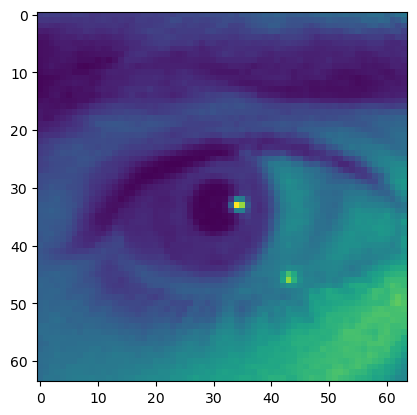

Open
1/1 [==============================] - 0s 26ms/step


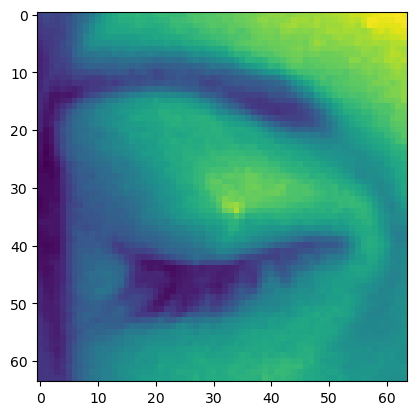

Closed
1/1 [==============================] - 0s 24ms/step


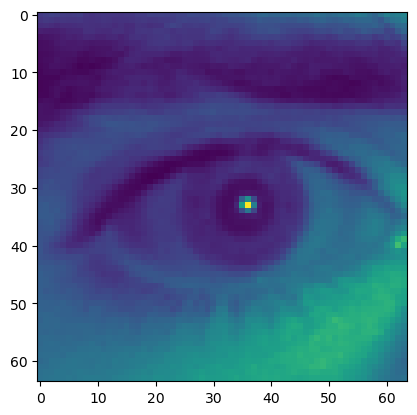

Open
1/1 [==============================] - 0s 58ms/step


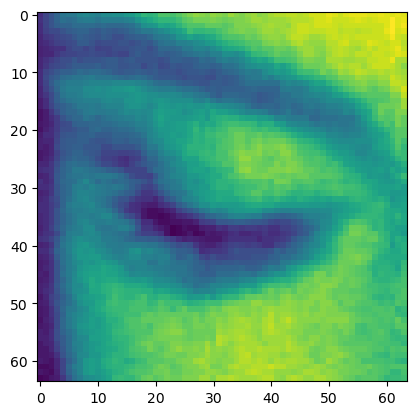

Closed
1/1 [==============================] - 0s 21ms/step


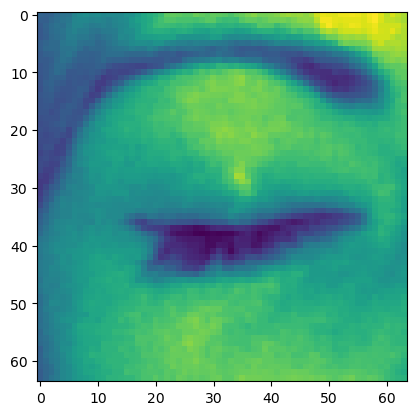

Closed


In [29]:
for i in x_test[0:5]:
    result = best_model.predict(np.expand_dims(i,0))
    plt.imshow(i)
    plt.show()
    
    if result > 0.5:
        print('Open')
    else:
        print("Closed")

### 13. Prediction and Confusion Matrix

42/42 [==============================] - 2s 36ms/step


Text(0.5, 25.722222222222214, 'Actual')

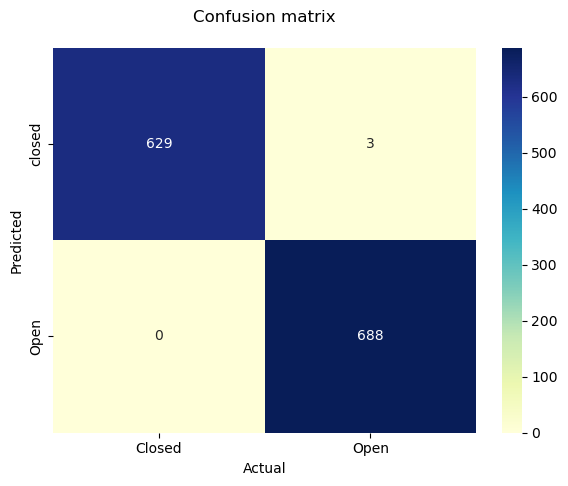

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 5))

preds = best_model.predict(x_test)
preds = (preds >= 0.5).astype(np.int32)
cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index=['closed', 'Open'], columns=['Closed', 'Open'])
plt.subplot(121)
plt.title("Confusion matrix\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

### 14. Accuracy

In [31]:
accuracy = best_model.evaluate(x_test, y_test)[1]
print("Accuracy:", accuracy)

42/42 [==============================] - 1s 32ms/step - loss: 0.0125 - accuracy: 0.9977
Accuracy: 0.9977272748947144
